In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers

from tqdm import tqdm

# import glob
# import imageio
# import os
# import PIL
# import time

tf.__version__

'2.1.0'

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# train_images = np.stack((train_images, train_images, train_images), axis=3)
# train_images_color = train_images.copy()
# # train_images_color[train_images>0] = np.random.uniform(0, 255, train_images_color[train_images>0].shape)
# train_images_color[:, :, :, 1] = 0
# train_images_color[:, :, :, 2] = 0

In [3]:
def create_generator_model():
    gm = tf.keras.Sequential()
    gm.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    gm.add(layers.BatchNormalization())
    gm.add(layers.LeakyReLU())

    gm.add(layers.Reshape((7, 7, 256)))
    assert gm.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    gm.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert gm.output_shape == (None, 7, 7, 128)
    gm.add(layers.BatchNormalization())
    gm.add(layers.LeakyReLU())

    gm.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert gm.output_shape == (None, 14, 14, 64)
    gm.add(layers.BatchNormalization())
    gm.add(layers.LeakyReLU())

    gm.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert gm.output_shape == (None, 28, 28, 1)

    return gm
    

In [4]:
def create_discriminator_model():
    dm = tf.keras.Sequential()
    dm.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Flatten())
    dm.add(layers.Dense(1))

    return dm

In [5]:
gm = create_generator_model()
dm = create_discriminator_model()

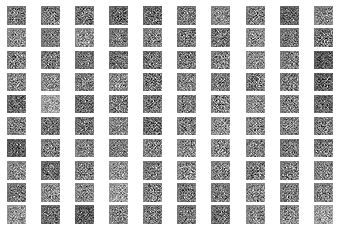

In [6]:
rows = 10
columns = 10
vis_noises = np.random.normal(0, 1, (rows*columns, 100))

def show_generator_model_images(gm):
    imgs = gm.predict(vis_noises)
    
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
#         plt.colorbar()
        plt.axis('off')
show_generator_model_images(gm)

In [7]:
g_optim = tf.keras.optimizers.Adam(1e-4)
d_optim = tf.keras.optimizers.Adam(1e-4)

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# real_output is the output of discriminator with real input images
# fake_output is the output of discriminator with fake input images
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # want to correctly identify real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # want to correctly identify fake
    return real_loss + fake_loss

# fake_output is the output of discriminator with fake input images
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # want to trick discriminator with fake output

In [9]:
@tf.function
def train_step(image_batch):
    noise = np.random.normal(0, 1, (image_batch.shape[0], 100))
    
    # gradient tapes needed to keep track of gradients (auto differentiation)
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_image_batch = gm(noise, training=True) # run generator to get fake images
        
        real_output = dm(image_batch[..., None], training=True) # run discriminator on real images
        fake_output = dm(fake_image_batch, training=True) # run discriminator on fake images
        
        g_loss = generator_loss(fake_output) # needs one for loss function, only the one it generated
        d_loss = discriminator_loss(real_output, fake_output) # needs both for loss function

    g_grad = g_tape.gradient(g_loss, gm.trainable_variables)
    d_grad = d_tape.gradient(d_loss, dm.trainable_variables)
    
    g_optim.apply_gradients(zip(g_grad, gm.trainable_variables))
    d_optim.apply_gradients(zip(d_grad, dm.trainable_variables))

In [10]:
batch_size = 100

def train(images, epochs):
    for epoch in range(epochs):
        for i_batch in tqdm(range(int(images.shape[0]/batch_size))):
            image_batch = images[i_batch*batch_size:(i_batch+1)*batch_size]
            train_step(image_batch)
            
            if i_batch%10==0:
                show_generator_model_images(gm)
                plt.savefig(f'mnist_gan/epoch_{epoch:03d}_step_{i_batch:03d}')
                plt.close()


In [ ]:
train((train_images-127.5)/127.5, 10)

  0%|          | 0/600 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0405 02:05:45.434586 4732640704 base_layer.py:1790] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0405 02:05:45.611742 4732640704 base_layer.py:1790] Layer conv2d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavio